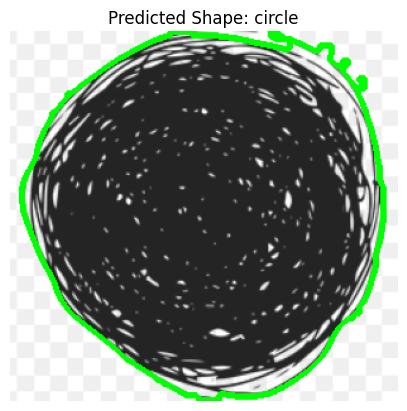

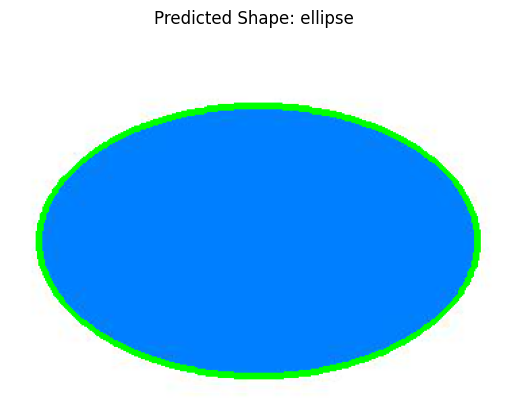

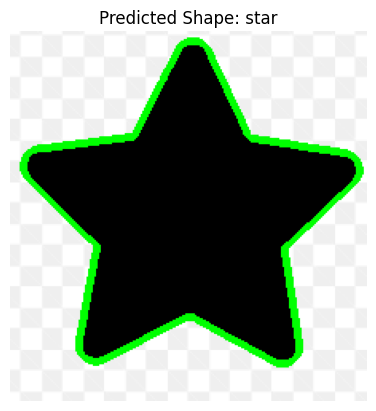

In [ ]:
#3.
#solution-1 using cv2 and svm libraries.
import cv2
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def generate_shape(shape_type, img_size=200):
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    center = (img_size // 2, img_size // 2)
    size = img_size // 4

    shape_img = np.zeros((img_size, img_size), dtype=np.uint8)

    if shape_type == 'square':
        cv2.rectangle(shape_img, (center[0]-size, center[1]-size), (center[0]+size, center[1]+size), 255, -1)

    elif shape_type == 'rectangle':
        rect_w = int(size * np.random.uniform(1.5, 2.5))
        rect_h = int(size * np.random.uniform(0.5, 1.0))
        cv2.rectangle(shape_img,
                      (center[0]-rect_w//2, center[1]-rect_h//2),
                      (center[0]+rect_w//2, center[1]+rect_h//2),
                      255, -1)

    elif shape_type == 'circle':
        cv2.circle(shape_img, center, size, 255, -1)

    elif shape_type == 'ellipse':
        axis = (size, int(size * 0.6))
        cv2.ellipse(shape_img, center, axis, 0, 0, 360, 255, -1)

    elif shape_type == 'star':
        pts = []
        for i in range(10):
            angle = i * np.pi / 5
            r = size if i % 2 == 0 else size // 2
            x = int(center[0] + r * np.cos(angle))
            y = int(center[1] + r * np.sin(angle))
            pts.append((x, y))
        pts = np.array(pts, np.int32)
        cv2.fillPoly(shape_img, [pts], 255)

    angle = np.random.uniform(0, 360)
    rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(shape_img, rot_matrix, (img_size, img_size), flags=cv2.INTER_NEAREST)

    return rotated

def extract_features(contour):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    _, _, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / h if h != 0 else 0
    symmetry = min(w/h, h/w) if h != 0 else 0
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0

    if len(contour) >= 5:
        (_, _), (MA, ma), _ = cv2.fitEllipse(contour)
        eccentricity = np.sqrt(1 - (MA**2)/(ma**2)) if ma != 0 else 0
    else:
        eccentricity = 0

    epsilon = 0.02 * perimeter
    approx = cv2.approxPolyDP(contour, epsilon, True)
    vertices = len(approx)

    return [aspect_ratio, vertices, solidity, eccentricity, symmetry]

# Train \
shape_list = ['square', 'rectangle', 'circle', 'ellipse', 'star']
train_features = []
train_labels = []

for shape in shape_list:
    for _ in range(40):
        img = generate_shape(shape)
        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            features = extract_features(max(contours, key=cv2.contourArea))
            train_features.append(features)
            train_labels.append(shape)

train_features = np.array(train_features)
train_labels = np.array(train_labels)

# SVM Training
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_features)
clf = svm.SVC(kernel='rbf', C=10, gamma=0.1)
clf.fit(scaled_features, train_labels)

# Image preprocessing
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    return img, cleaned

# Prediction
def predict_shape(img_path):
    try:
        orig_img, processed_img = preprocess_image(img_path)
    except Exception as e:
        print(e)
        return None

    contours, _ = cv2.findContours(processed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    features = extract_features(contour)
    scaled_features = scaler.transform([features])
    prediction = clf.predict(scaled_features)[0]
    cv2.drawContours(orig_img, [contour], -1, (0, 255, 0), 3)
    plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Shape: {prediction}")
    plt.axis('off')
    plt.show()
    return prediction

if __name__ == "__main__":
    image_path = "/content/disorted circle.png"
    result = predict_shape(image_path)
    print()
    image_path = "/content/ellipse.png"
    result = predict_shape(image_path)
    print()
    image_path = "/content/star.png"
    result = predict_shape(image_path)


